C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Absolute Error (MAE): 509777.07
Root Mean Squared Error (RMSE): 571069.25
Mean Absolute Percentage Error (MAPE): 45.84%
R-squared (R²): -0.57
Precisão do Modelo: 54.16%
SMAPE: 35.88%
AIC: 1161.99
BIC: 1189.41
Ljung-Box Test P-value: 0.2645


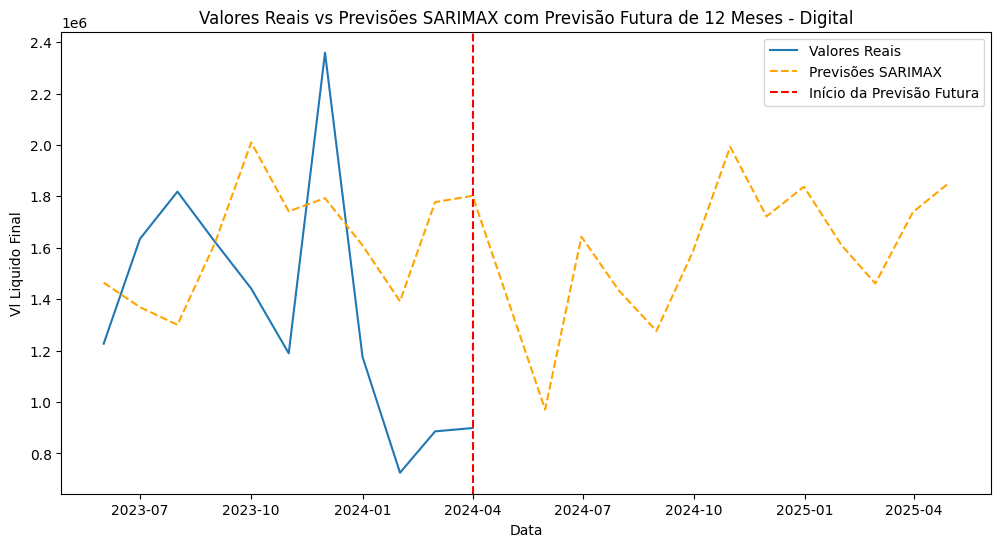

<Figure size 1200x600 with 0 Axes>

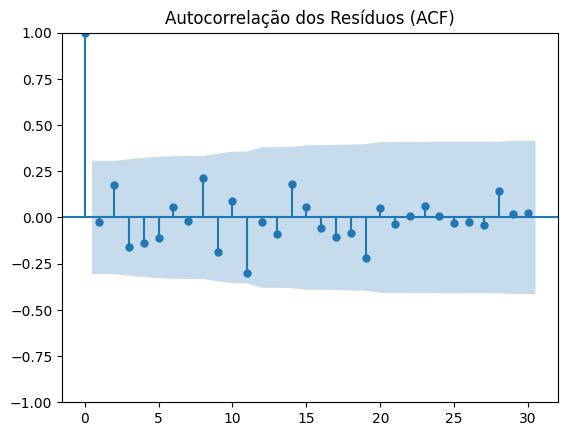

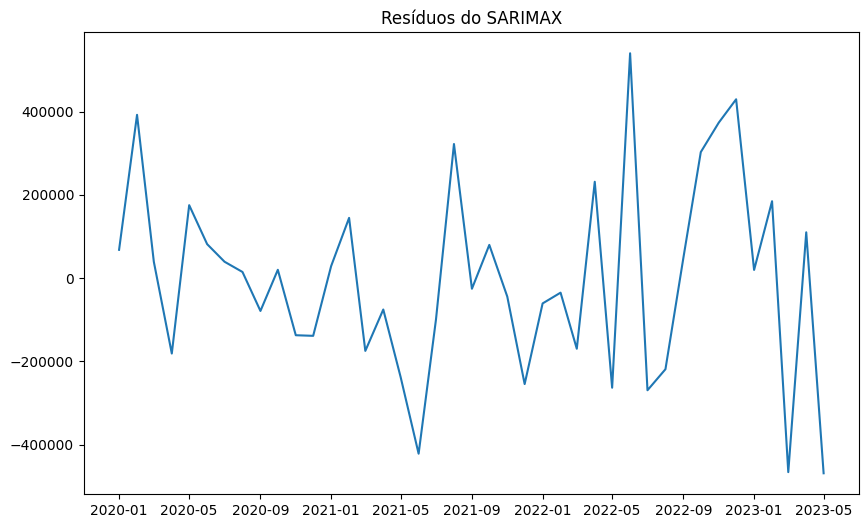

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# Carregar o DataFrame de Digital
df_digital = pd.read_csv('../../df_digital.csv')

# Define a coluna 'Data' como índice e converte para datetime
df_digital['Data'] = pd.to_datetime(df_digital['Data'])  # Converte a coluna Data para datetime
df_digital.set_index('Data', inplace=True)

# Remover variáveis exógenas menos relevantes e sem lags (atualize conforme o dataset)
X = df_digital.drop(columns=['Vl Liquido Final', 'Vl Bruto', 'VL Tabela', 'Setor', 
                             'PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR'])  # Ajuste as colunas conforme necessário
y = df_digital['Vl Liquido Final']

# Garantir que os índices de X e y estejam alinhados
X, y = X.align(y, join='inner', axis=0)

# Escalar os dados de entrada (se necessário, você pode adicionar StandardScaler se quiser normalizar as features)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Divida os dados em treinamento e teste (80% para treinamento, 20% para teste)
train_size = int(len(y) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Função para calcular o SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Treinando o modelo SARIMAX com os parâmetros recomendados
model = SARIMAX(train_y, exog=train_X, order=(1, 0, 0), seasonal_order=(1, 0, 2, 12))
model_fit = model.fit(disp=False)

# Previsão no conjunto de teste
forecast_test = model_fit.forecast(steps=len(test_y), exog=test_X)

# Previsão futura de 12 meses
future_steps = 12
future_dates = pd.date_range(start=pd.to_datetime(test_y.index[-1]) + pd.DateOffset(months=1), periods=future_steps, freq='M')
forecast_future = model_fit.forecast(steps=future_steps, exog=X.iloc[-future_steps:])

# Combine previsões de teste e futuras
all_forecast = np.concatenate([forecast_test, forecast_future])
all_dates = test_y.index.append(future_dates)

# Calcule as métricas de avaliação
mae = mean_absolute_error(test_y, forecast_test)
rmse = np.sqrt(mean_squared_error(test_y, forecast_test))
mape = np.mean(np.abs((test_y - forecast_test) / test_y)) * 100
r2 = r2_score(test_y, forecast_test)
precision = 100 - mape
smape_value = smape(test_y, forecast_test)
aic = model_fit.aic
bic = model_fit.bic
ljung_box_test = acorr_ljungbox(model_fit.resid, lags=[12], return_df=True)

# Exiba as métricas
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")
print(f"Precisão do Modelo: {precision:.2f}%")
print(f"SMAPE: {smape_value:.2f}%")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"Ljung-Box Test P-value: {ljung_box_test['lb_pvalue'].values[0]:.4f}")

# Plotando os valores reais, as previsões e a previsão futura
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y, label='Valores Reais')
plt.plot(all_dates, all_forecast, label='Previsões SARIMAX', linestyle='--', color='orange')
plt.axvline(x=test_y.index[-1], color='red', linestyle='--', label='Início da Previsão Futura')
plt.xlabel('Data')
plt.ylabel('Vl Liquido Final')
plt.title(f'Valores Reais vs Previsões SARIMAX com Previsão Futura de 12 Meses - Digital')
plt.legend()
plt.show()

# Plot de autocorrelação dos resíduos (ACF)
plt.figure(figsize=(12, 6))
plot_acf(model_fit.resid, lags=30)
plt.title('Autocorrelação dos Resíduos (ACF)')
plt.show()

# Plot dos resíduos
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Resíduos do SARIMAX')
plt.show()
